In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from time import perf_counter
import os
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Flatten
from sklearn.metrics import classification_report, confusion_matrix,precision_recall_fscore_support, roc_curve, auc,accuracy_score,precision_recall_curve, f1_score, roc_curve
import keras
import re
import warnings
warnings.filterwarnings("ignore")

### load data 

In [10]:
data_train='/kaggle/input/ahcd1/Train Images 13440x32x32/train'
data_test='/kaggle/input/ahcd1/Test Images 3360x32x32/test'

In [11]:
arabic_labels = ['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain', 
                'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh']

In [40]:
file_train = os.listdir(data_train)
file_test = os.listdir(data_test)



In [41]:
#function for extract class name from file name
map_label={
    1:'alef',2:'beh',3:'teh',4:'theh',5:'jeem',6:'hah',
    7:'khah',8:'dal',9:'thal',10:'reh',11:'zain',12:'seen',
    13:'sheen',14:'sad',15:'dad',16:'tah',17:'zah',18:'ain',
    19:'ghain',20:'feh',21:'qaf',22:'kaf',23:'lam',24:'meem',
    25:'noon',26:'heh',27:'waw',28:'yeh'
}
def class_name(text):
    text=re.split(r'[_\.]', text)[-2] 
    label = map_label.get(int(text))
    return label


In [42]:

train_imag_labels = []
test_images_labels = []

# Load the train images and labels
for file_name in file_train:
    if file_name.endswith('.png'):
        image = cv2.imread(os.path.join(data_train, file_name))
        train_imag_labels.append([image,class_name(file_name)])
for file_name in file_test:
    if file_name.endswith('.png'):
        image = cv2.imread(os.path.join(data_test, file_name))
        test_images_labels.append([image,class_name(file_name)])
        


In [43]:
trainDF=pd.DataFrame(train_imag_labels,columns = ['image','label'])
trainDF.head()

,image,label
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",waw
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",teh
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",meem
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",alef
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",teh


In [44]:
testDF = pd.DataFrame(test_images_labels, columns=['image', 'label'])
testDF.head()

,image,label
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",lam
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",sad
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",qaf
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",zah
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",heh


### visualize the data

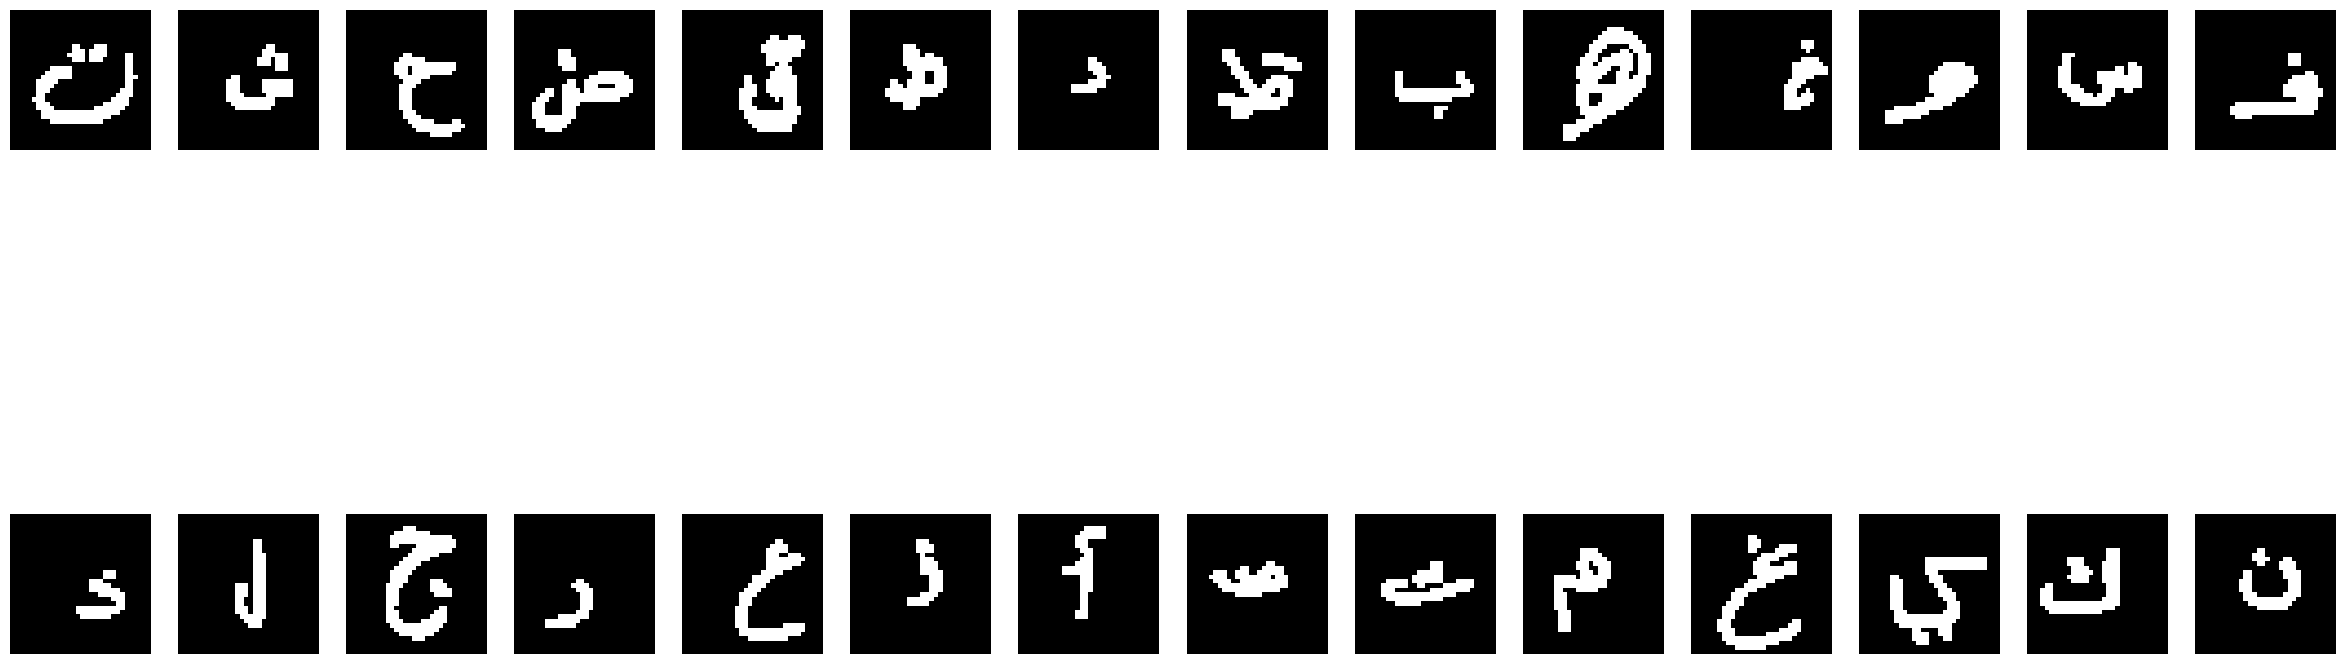

In [45]:
fig, ax = plt.subplots(2, 14, figsize=(30, 12))

labels = set(trainDF['label'])
labels = list(labels)[:29] 
for i, name in enumerate(labels):
    row = i // 14  # row index
    col = i % 14  # column index

    sample = trainDF[trainDF['label'] == name].sample(1)
    image = sample['image'].item()

    ax[row, col].imshow(image)
    ax[row, col].axis('off')

plt.show()

In [46]:
print("Missing values:",trainDF['label'].isnull().sum())

Missing values: 0


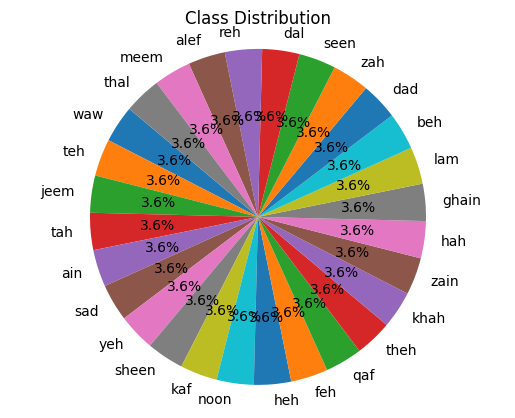

In [47]:
balance=trainDF['label'].value_counts()
plt.pie(balance.values, labels=balance.index,
        autopct='%1.1f%%', startangle=140)

plt.axis('equal')

plt.title('Class Distribution')

plt.show()

### Reshape the data 

In [48]:
N = trainDF.shape[0]
x_train = np.empty((N, 32, 32, 3), dtype=np.uint8)
for i, image in enumerate((trainDF['image'])):
    x_train[i, :, :, :] = image

In [49]:
N = testDF.shape[0]
x_test = np.empty((N, 32, 32, 3), dtype=np.uint8)
for i, image in enumerate((testDF['image'])):
    x_test[i, :, :, :] = image


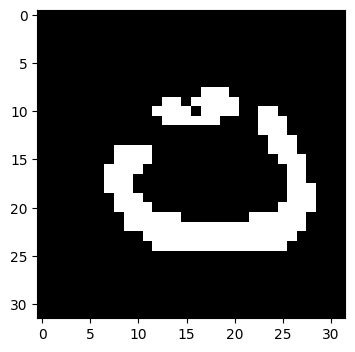

In [50]:
plt.figure(figsize=(4,4))
plt.imshow(x_train[1])


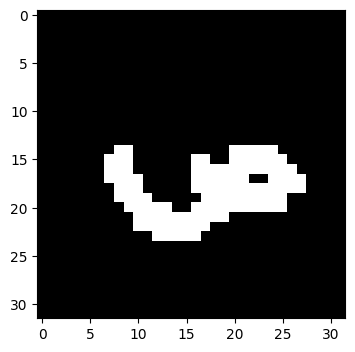

In [51]:
plt.figure(figsize=(4,4))
plt.imshow(x_test[1])


In [52]:
print('Shape of train images:',x_train .shape)
print('Shape of test images:', x_test.shape)

Shape of train images: (13440, 32, 32, 3)
Shape of test images: (3360, 32, 32, 3)


### Preprocessing

In [53]:
#converting labels from string to int
le = LabelEncoder()
y_train=le.fit_transform(trainDF['label'])
#convert integer labels into one-hot encoded vectors ,28 are the alphapets
y_train=to_categorical(y_train, num_classes=28)


y_test=le.transform(testDF['label'])
#convert integer labels into one-hot encoded vectors ,28 are the alphapets
y_test=to_categorical(y_test, num_classes=28)


In [54]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

### CNN model

In [55]:
def cnn_model(input_shape,num_class):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu',  input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5)) 
    
    model.add(Dense(num_class, activation='softmax'))
    return model


In [59]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,828 (362.61 KB)

 Trainable params: 92,828 (362.61 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
model=cnn_model((32, 32, 3), 28)

In [61]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [62]:
history=model.fit(x_train, y_train,validation_data=(x_val, y_val),epochs=10, batch_size=32, verbose=1)

Epoch 1/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.0677 - loss: 8.4041 - val_accuracy: 0.2980 - val_loss: 2.4187
Epoch 2/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.2692 - loss: 2.4259 - val_accuracy: 0.5517 - val_loss: 1.4551
Epoch 3/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.4612 - loss: 1.6722 - val_accuracy: 0.6548 - val_loss: 1.0582
Epoch 4/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5860 - loss: 1.2735 - val_accuracy: 0.7080 - val_loss: 0.8801
Epoch 5/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.6589 - loss: 1.0376 - val_accuracy: 0.7604 - val_loss: 0.7319
Epoch 6/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7189 - loss: 0.8435 - val_accuracy: 0.7972 - val_loss: 0.6103
Epoch 7/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.7616 - loss: 0.7158 - val_accuracy: 0.8374 - val_loss: 0.5189
Epoch 8/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.7894 - loss: 0.6451 - val_acc

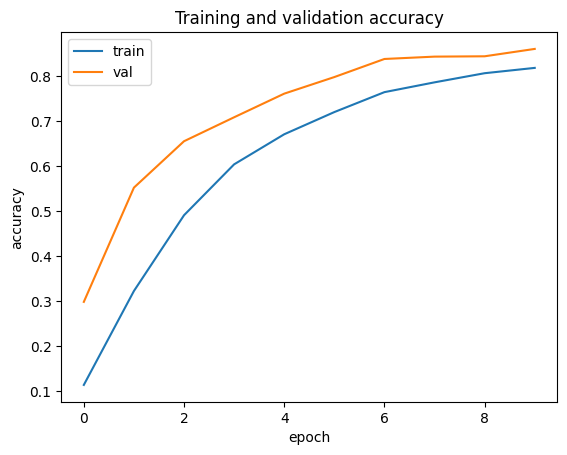

In [63]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [64]:
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)  
y_test_labels = np.argmax(y_test, axis=1)  

accuracy = accuracy_score(y_test_labels, y_pred)
print("Accuracy:", accuracy)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Accuracy: 0.8550595238095238


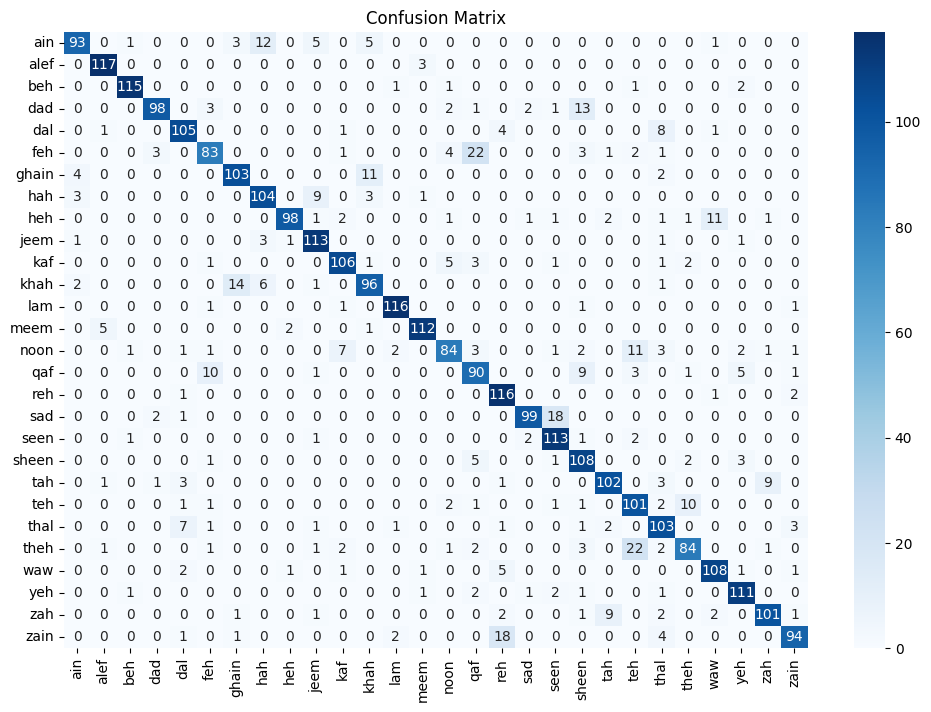

In [65]:
cm=confusion_matrix(y_test_labels,y_pred)
plt.figure(figsize=(12, 8)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.show()

In [66]:
print(classification_report(y_test_labels, y_pred,target_names=le.classes_))

              precision    recall  f1-score   support

         ain       0.90      0.78      0.83       120
        alef       0.94      0.97      0.96       120
         beh       0.97      0.96      0.96       120
         dad       0.94      0.82      0.87       120
         dal       0.86      0.88      0.87       120
         feh       0.81      0.69      0.74       120
       ghain       0.84      0.86      0.85       120
         hah       0.83      0.87      0.85       120
         heh       0.96      0.82      0.88       120
        jeem       0.84      0.94      0.89       120
         kaf       0.88      0.88      0.88       120
        khah       0.82      0.80      0.81       120
         lam       0.95      0.97      0.96       120
        meem       0.95      0.93      0.94       120
        noon       0.84      0.70      0.76       120
         qaf       0.70      0.75      0.72       120
         reh       0.79      0.97      0.87       120
         sad       0.94    

### Cross validation 

### kf = KFold(n_splits=5)  # 5-fold cross-validation
accuracies = []

for train_index, val_index in kf.split(x_train):
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Create and compile the model
    model =cnn_model((32, 32, 3), 28)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(x_train_fold, y_train_fold, epochs=10, batch_size=32, validation_data=(x_val_fold, y_val_fold), verbose=1)

    # Evaluate the model
    y_val_pred = model.predict(x_val_fold)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_val_fold, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    accuracies.append(accuracy)
    print(f'Fold accuracy: {accuracy:.4f}')

print(f'Average accuracy across folds: {np.mean(accuracies):.4f}')